# Predict purchase 

## File structure
**event_time**

Time when event happened at (in UTC).

**event_type**

Events can be:

* view - a user viewed a product
* cart - a user added a product to shopping cart
* removefromcart - a user removed a product from shopping cart
* purchase - a user purchased a product
Typical funnel: view => cart => purchase.

**product_id**

ID of a product

**category_id**

Product's category ID

**category_code**

Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.

**brand**

Downcased string of brand name. Can be missed.

**price**

Float price of a product. Present.

**user_id**

Permanent user ID.

**user_session**

Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.

## Multiple purchases per session
A session can have multiple purchase events. It's ok, because it's a single order.


data downloaded: https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store  
data source: https://rees46.com/  

## Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import os
from datetime import datetime
import random
import gc
import pickle

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,IntegerType,StringType,DateType,FloatType,StructField,TimestampType
from pyspark.sql.functions import *
import pyspark_jobs

In [4]:
spark = SparkSession \
        .builder \
        .appName("Predict promo") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory","4g") \
        .config("spark.ui.showConsoleProgress","True")\
        .getOrCreate()

In [4]:
schema = StructType([
   StructField("event_time", StringType(), True),
   StructField("event_type", StringType(), True),
   StructField("product_id", IntegerType(), True),
   StructField("category_id", StringType(), True),
   StructField("category_code", StringType(), True),
   StructField("brand", StringType(), True),
   StructField("price", FloatType(), True),
   StructField("user_id", IntegerType(), True),
   StructField("user_session", StringType(), True)])

In [5]:
df = spark.read.format('csv').load('Data/2019-Oct.csv',header=True,schema=schema)

In [6]:
df.show(5)

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

In [7]:
df = df.na.drop()

In [8]:
df = df.withColumn('event_time',df.event_time.substr(1,19).cast(TimestampType()))

In [9]:
df = df.withColumn('hour',hour(df.event_time))\
    .withColumn('day_of_week',dayofweek(df.event_time))\
    .withColumn('day_of_month',dayofmonth(df.event_time))\
    .withColumn('month',month(df.event_time))\
    .withColumn('year',year(df.event_time))\
    .withColumn('category',split(df.category_code,"\.").getItem(0))\
    .withColumn('subcategory',split(df.category_code,"\.").getItem(1))

In [10]:
df = df.drop('category_code')

In [11]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)



In [12]:
# df.groupby(['user_session','user_id']).count().show(5)
cnt = df.groupBy(['user_session','user_id']).count().select('user_session','user_id', col('count').alias('activity_count'))
# df = df.join(cnt.select(,on=[df.user_session==cnt.user_session,df.user_id==df.user_id])
# df.show(5)

In [15]:
df = df.join(cnt, ['user_session','user_id'])
df.show(5)

+--------------------+---------+-------------------+----------+----------+-------------------+-------+------+----+-----------+------------+-----+----+----------+--------------+--------------+
|        user_session|  user_id|         event_time|event_type|product_id|        category_id|  brand| price|hour|day_of_week|day_of_month|month|year|  category|   subcategory|activity_count|
+--------------------+---------+-------------------+----------+----------+-------------------+-------+------+----+-----------+------------+-----+----+----------+--------------+--------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:26:06|      view|   5000556|2053013566100866035|brother|780.53|  13|          7|          26|   10|2019|appliances|sewing_machine|             3|
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|  purchase|   5000556|2053013566100866035|brother|780.53|  13|          7|          26|   10|2019|appliances|sewing_machine|             3|
|0003726c-81ad-49c...|515826621|2019-10-

In [18]:
from pyspark.sql import Window
window = Window.partitionBy('user_session','user_id').orderBy('event_time')
df = df.withColumn('prev_activity',lag('activity_count',1).over(window))
df.show(5)

+--------------------+---------+-------------------+----------+----------+-------------------+-------+------+----+-----------+------------+-----+----+----------+--------------+--------------+-------------+
|        user_session|  user_id|         event_time|event_type|product_id|        category_id|  brand| price|hour|day_of_week|day_of_month|month|year|  category|   subcategory|activity_count|prev_activity|
+--------------------+---------+-------------------+----------+----------+-------------------+-------+------+----+-----------+------------+-----+----+----------+--------------+--------------+-------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:26:06|      view|   5000556|2053013566100866035|brother|780.53|  13|          7|          26|   10|2019|appliances|sewing_machine|             3|         null|
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|  purchase|   5000556|2053013566100866035|brother|780.53|  13|          7|          26|   10|2019|appliances|sewing_machine|

In [20]:
from itertools import chain
d = {'purchase':1,'view':0,'cart':0}
mapping = create_map([lit(x) for x in chain(*d.items())])
df = df.withColumn('is_purchased',coalesce(mapping[df['event_type']],df['event_type']).alias('is_purchased'))
df.show(5)

+--------------------+---------+-------------------+----------+----------+-------------------+-------+------+----+-----------+------------+-----+----+----------+--------------+--------------+-------------+------------+
|        user_session|  user_id|         event_time|event_type|product_id|        category_id|  brand| price|hour|day_of_week|day_of_month|month|year|  category|   subcategory|activity_count|prev_activity|is_purchased|
+--------------------+---------+-------------------+----------+----------+-------------------+-------+------+----+-----------+------------+-----+----+----------+--------------+--------------+-------------+------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:26:06|      view|   5000556|2053013566100866035|brother|780.53|  13|          7|          26|   10|2019|appliances|sewing_machine|             3|         null|           0|
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|  purchase|   5000556|2053013566100866035|brother|780.53|  13|          

In [21]:
df = df.withColumn('prev_purchase',lag('is_purchased',1).over(window))
df.show()

+--------------------+---------+-------------------+----------+----------+-------------------+-------+-------+----+-----------+------------+-----+----+-----------+--------------+--------------+-------------+------------+-------------+
|        user_session|  user_id|         event_time|event_type|product_id|        category_id|  brand|  price|hour|day_of_week|day_of_month|month|year|   category|   subcategory|activity_count|prev_activity|is_purchased|prev_purchase|
+--------------------+---------+-------------------+----------+----------+-------------------+-------+-------+----+-----------+------------+-----+----+-----------+--------------+--------------+-------------+------------+-------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:26:06|      view|   5000556|2053013566100866035|brother| 780.53|  13|          7|          26|   10|2019| appliances|sewing_machine|             3|         null|           0|         null|
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|  purcha

In [31]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCols=['event_type','brand','category','subcategory'],outputCols=['event_type_tr','brand_tr','category_tr','subcategory_tr'])
indexed = indexer.fit(df).transform(df)
indexed.show(5)

+--------------------+---------+-------------------+----------+----------+-------------------+-------+------+----+-----------+------------+-----+----+----------+--------------+--------------+-------------+------------+-------------+-------------+--------+-----------+--------------+
|        user_session|  user_id|         event_time|event_type|product_id|        category_id|  brand| price|hour|day_of_week|day_of_month|month|year|  category|   subcategory|activity_count|prev_activity|is_purchased|prev_purchase|event_type_tr|brand_tr|category_tr|subcategory_tr|
+--------------------+---------+-------------------+----------+----------+-------------------+-------+------+----+-----------+------------+-----+----+----------+--------------+--------------+-------------+------------+-------------+-------------+--------+-----------+--------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:26:06|      view|   5000556|2053013566100866035|brother|780.53|  13|          7|          26|   10|2019|a

In [37]:
import pyspark_jobs
schema = {'prev_activity':'int','prev_purchase':'int','is_purchased':'int'}
indexed = pyspark_jobs.change_col_type(indexed,schema)
indexed.printSchema()

root
 |-- user_session: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- price: float (nullable = false)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- activity_count: long (nullable = false)
 |-- prev_activity: integer (nullable = true)
 |-- is_purchased: integer (nullable = true)
 |-- prev_purchase: integer (nullable = true)
 |-- event_type_tr: double (nullable = false)
 |-- brand_tr: double (nullable = false)
 |-- category_tr: double (nullable = false)
 |-- subcategory_tr: double (nullable = false)



In [32]:
indexed = indexed.drop('event_type','brand','category','subcategory')
indexed.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+-------------+-------------+--------+-----------+--------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchase|event_type_tr|brand_tr|category_tr|subcategory_tr|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+-------------+-------------+--------+-----------+--------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:26:06|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|         null|           0|         null|          0.0|   186.0|        1.0|          20.0|
|0003726c-81ad-49c...|515826621|2019-10-26 13:27

In [38]:
indexed = indexed.fillna(0)
indexed.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+-------------+-------------+--------+-----------+--------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchase|event_type_tr|brand_tr|category_tr|subcategory_tr|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+-------------+-------------+--------+-----------+--------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:26:06|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|            0|           0|            0|          0.0|   186.0|        1.0|          20.0|
|0003726c-81ad-49c...|515826621|2019-10-26 13:27

In [48]:
indexed.repartition(1).write.csv("Data/preprocessed.csv", sep=',')

In [29]:
schema = StructType([
   StructField("user_session", StringType(), True),
   StructField("user_id", IntegerType(), True),
   StructField("event_time", TimestampType(), True),
   StructField("product_id", IntegerType(), True),
   StructField("category_id", StringType(), True),
   StructField("price", FloatType(), True),
   StructField("hour", IntegerType(), True),
   StructField("day_of_week", IntegerType(), True),
   StructField("day_of_month", IntegerType(), True),
   StructField("month", IntegerType(), True),
   StructField("year", IntegerType(), True),
   StructField("activity_count", IntegerType(), True),
   StructField("prev_activity", IntegerType(), True),
   StructField("is_purchased", IntegerType(), True),
   StructField("prev_purchased", IntegerType(), True),
   StructField("event_type_tr", FloatType(), True),
   StructField("brand_tr", FloatType(), True),
   StructField("category_tr", FloatType(), True),
   StructField("subcategory_tr", FloatType(), True)])


In [30]:
df = spark.read.format('csv').load('Data/preprocessed.csv',header =True,enforceSchema=True,schema=schema)

In [31]:
df.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchased|event_type_tr|brand_tr|category_tr|subcategory_tr|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|            3|           1|             0|          2.0|   186.0|        1.0|          20.0|
|0003726c-81ad-49c...|515826621|2019-10-26 1

In [32]:
df.printSchema()

root
 |-- user_session: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- price: float (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- activity_count: integer (nullable = true)
 |-- prev_activity: integer (nullable = true)
 |-- is_purchased: integer (nullable = true)
 |-- prev_purchased: integer (nullable = true)
 |-- event_type_tr: float (nullable = true)
 |-- brand_tr: float (nullable = true)
 |-- category_tr: float (nullable = true)
 |-- subcategory_tr: float (nullable = true)



In [36]:
from pyspark.ml.feature import StandardScaler,VectorAssembler

cols = ['price','hour','day_of_week','day_of_month','month','year','activity_count','prev_activity','prev_purchased','event_type_tr','brand_tr','category_tr','subcategory_tr']
assembler = VectorAssembler().setInputCols(cols).setOutputCol('features')
transformed = assembler.transform(df)

scaler = StandardScaler(inputCol='features',outputCol='scaledFeatures')
model  = scaler.fit(transformed.select('features'))
scaled_features = model.transform(transformed)

In [39]:
model.save('PickledObjects/scaler')

In [41]:
assembler.save('PickledObjects/assembler')

In [42]:
scaled_features.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+--------------------+--------------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchased|event_type_tr|brand_tr|category_tr|subcategory_tr|            features|      scaledFeatures|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+--------------------+--------------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|           

In [43]:
scaled_features = scaled_features.drop('features')

In [44]:
scaled_features.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+--------------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchased|event_type_tr|brand_tr|category_tr|subcategory_tr|      scaledFeatures|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+--------------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|            3|           1|             0|          2.0|   186.0|        1

In [47]:
scaled_features.repartition(1).write.json("Data/preprocessed_features.json")

## Model training

In [53]:
scaled_features = scaled_features.withColumnRenamed('is_purchased','label')
scaled_features.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+-----+--------------+-------------+--------+-----------+--------------+--------------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|label|prev_purchased|event_type_tr|brand_tr|category_tr|subcategory_tr|      scaledFeatures|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+-----+--------------+-------------+--------+-----------+--------------+--------------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|            3|    1|             0|          2.0|   186.0|        1.0|          20.0|[2.0481976

In [56]:
train,test = scaled_features.select('scaledFeatures','label').randomSplit([0.7,0.3],45)

In [63]:
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(featuresCol='scaledFeatures', labelCol='label', predictionCol='prediction',\
                           maxIter=500, regParam=0.001, elasticNetParam=0.0, tol=1e-06, fitIntercept=True,\
                           threshold=0.5,aggregationDepth=2, family='auto').fit(train)


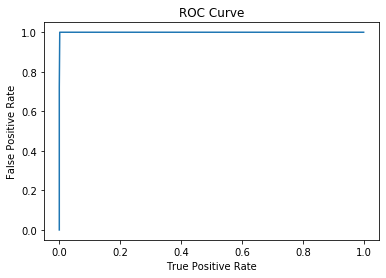

Training set ROC: 0.9997904712884416


In [66]:
import matplotlib.pyplot as plt

trainingSummary = model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [67]:
trainingSummary.accuracy

1.0

In [68]:
pred = model.transform(test)

In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.9999997598778658


In [72]:
trainingSummary.fMeasureByLabel()

[1.0, 1.0]

In [73]:
trainingSummary.precisionByLabel

[1.0, 1.0]

## New

In [74]:
from pyspark.ml.feature import StandardScaler,VectorAssembler

cols = ['price','hour','day_of_week','day_of_month','month','year','activity_count','event_type_tr','brand_tr','category_tr','subcategory_tr']
assembler = VectorAssembler().setInputCols(cols).setOutputCol('features')
transformed = assembler.transform(df)

scaler = StandardScaler(inputCol='features',outputCol='scaledFeatures')
model  = scaler.fit(transformed.select('features'))
scaled_features = model.transform(transformed)

In [39]:
# model.save('PickledObjects/scaler')

In [41]:
# assembler.save('PickledObjects/assembler')

In [75]:
scaled_features.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+--------------------+--------------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchased|event_type_tr|brand_tr|category_tr|subcategory_tr|            features|      scaledFeatures|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+--------------------+--------------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|           

In [76]:
scaled_features = scaled_features.drop('features')

In [77]:
scaled_features.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+--------------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchased|event_type_tr|brand_tr|category_tr|subcategory_tr|      scaledFeatures|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+--------------+-------------+--------+-----------+--------------+--------------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|            3|           1|             0|          2.0|   186.0|        1

In [78]:
# scaled_features.repartition(1).write.json("Data/preprocessed_features.json")

## Model training

In [79]:
scaled_features = scaled_features.withColumnRenamed('is_purchased','label')
scaled_features.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+-----+--------------+-------------+--------+-----------+--------------+--------------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|label|prev_purchased|event_type_tr|brand_tr|category_tr|subcategory_tr|      scaledFeatures|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+-----+--------------+-------------+--------+-----------+--------------+--------------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             3|            3|    1|             0|          2.0|   186.0|        1.0|          20.0|[2.0481976

In [80]:
train,test = scaled_features.select('scaledFeatures','label').randomSplit([0.7,0.3],45)

In [81]:
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(featuresCol='scaledFeatures', labelCol='label', predictionCol='prediction',\
                           maxIter=500, regParam=0.001, elasticNetParam=0.0, tol=1e-06, fitIntercept=True,\
                           threshold=0.5,aggregationDepth=2, family='auto').fit(train)


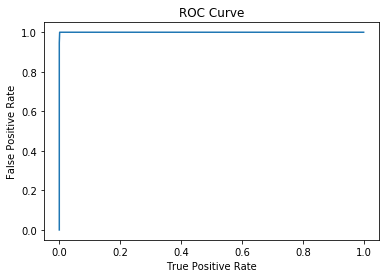

Training set ROC: 0.9999669615087556


In [82]:
import matplotlib.pyplot as plt

trainingSummary = model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [83]:
trainingSummary.accuracy

1.0

In [84]:
pred = model.transform(test)

In [85]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.9999971702643708


In [86]:
trainingSummary.fMeasureByLabel()

[1.0, 1.0]

In [87]:
trainingSummary.precisionByLabel

[1.0, 1.0]

In [88]:
spark.stop()